<a href="https://colab.research.google.com/github/snxly/colab/blob/master/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API
## python
- random.seed
- random.shuffle
## pytorch
- cat # concat
- unbind
- linspace
- F.cross_entropy

# Init (imports, utilities, etc)

In [106]:
# imports
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [ ]:
# get file
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [6]:
# get words
words = open('names.txt', 'r').read().splitlines()
# init utility s2i and i2s
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


# Network Diagram

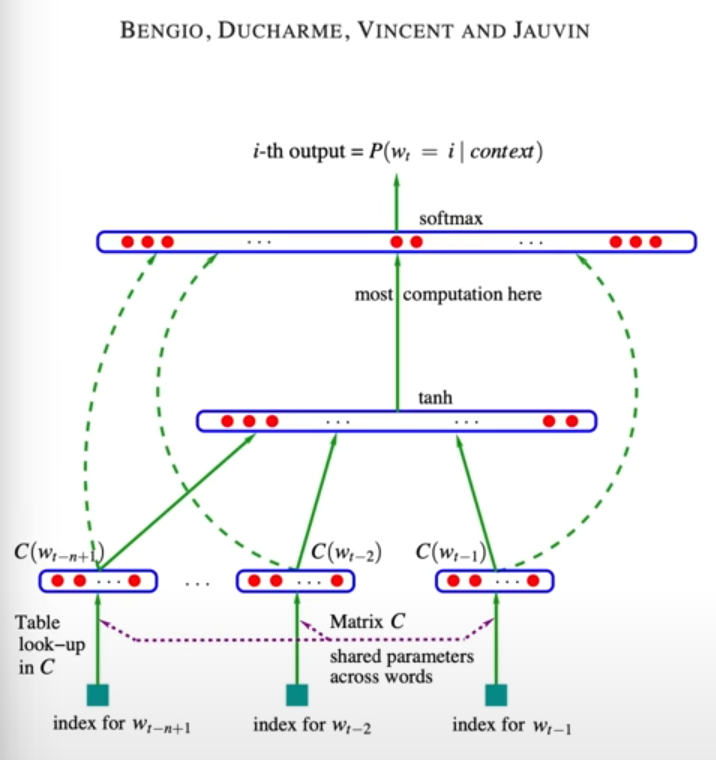

# Setup Model

## Step by Step

In [ ]:
# setup the dataset
block_size = 3
xs = []
ys = []
for w in words[:5]:
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    xs.append(context)
    ys.append(stoi[ch])
    print(''.join(itos[con] for con in context), '---->', ch)
    context = context[1:] + [stoi[ch]]
X = torch.tensor(xs)
Y = torch.tensor(ys)
# xs, ys
X.shape, Y.shape


In [29]:
# init wights
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

C = torch.randn((27, 2))

# setup input embeddings
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [38]:
# 这里很重要
# 现在我得到了一个 shape = (32,3,2) 的 input(emb)
# 我希望把这个input变成 shape = (32, 6) , 这样就可以 emb @ W
# 有几种办法可以做到
# 第一种：
#torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim=1).shape
# 第二种：解决 hardcode index的问题
# torch.cat(torch.unbind(emb, dim=1), dim=1).shape
# 第三种：view (reshape)
# emb.view(-1, 6)
# check result with
# emb.view(-1, 6) == torch.cat(torch.unbind(emb, dim=1), dim=1)
h = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(h)
h.shape

torch.Size([32, 100])

In [39]:
# output layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
logits = h @ W2 + b2 # log count
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
# get loss of Y
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(19.0041)

## All in One

In [ ]:
# init weights
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g, requires_grad=True)
W1 = torch.randn((6, 100), generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn((100, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]
pnum = sum(p.nelement() for p in parameters)
print('number of parameter is', pnum)
# setup training data
block_size = 3
xs = []
ys = []
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    xs.append(context)
    ys.append(stoi[ch])
    # print(''.join(itos[con] for con in context), '---->', ch)
    context = context[1:] + [stoi[ch]]
X = torch.tensor(xs)
Y = torch.tensor(ys)
# xs, ys
print('X shape is', X.shape)
print('Y shape is', Y.shape)


In [ ]:
# train the model
for i in range(10):
  # forward pass
  emb = C[X]
  h = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True)
  # get loss of Y,
  # average negative log likelihood
  loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
  print('loss is', loss)
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update weights
  for p in parameters:
    p.data += -0.1 * p.grad

# 改进1 - cross-entropy
## 计算loss的方式如下
1. 计算   logits (log-count) = x @ w
2. 计算   counts = logits.exp()
3. 计算   probs = counts / counts.sum(1, keepdim=True)
4. 计算   loss = -probs(troch.arange(Y.shape[0]), Y).log().mean()

## 以上的方式，就叫 cross-entropy，可用API计算
loss = F.cross_entropy(logits, Y)

In [ ]:
# train the model
for i in range(10):
  # forward pass
  emb = C[X]
  h = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  # counts = logits.exp()
  # probs = counts / counts.sum(1, keepdims=True)
  # # get loss of Y,
  # # average negative log likelihood
  # loss = -probs[torch.arange(X.shape[0]), Y].log().mean()
  loss = F.cross_entropy(logits, Y)
  print('loss is', loss)
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update weights
  for p in parameters:
    p.data += -0.1 * p.grad

# 改进2 - mini-batch update
用了mini-batch以后，100个iteration瞬间就跑完了

In [ ]:
# train the model with mini-batch
for i in range(100):
  # mini-batch
  idx = torch.randint(0, X.shape[0], (32,))
  X_batch = X[idx]
  Y_batch = Y[idx]
  # forward pass
  emb = C[X_batch]
  h = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch)
  print('loss is', loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update weights
  for p in parameters:
    p.data += -0.01 * p.grad

# 改进3 - learning rate (from 45:30)
如何选择合适的 learning rate， 来加速训练
0. 在mini-batch的基础上测试，loss变化不是单调的，但是仍可以观察趋势。
1. 首先，确定lr的上限和下限。如果下限过低，会发现loss几乎没有更新，这时可以提高下限10倍。比如检测到 0.001就稳步下降。如果上限过高，loss会爆炸，这时可以降低上限10倍，比如检测到1，loss就不会爆炸.
2. 在上限和下限之间，根据step选取不同的值，分别测试loss。然后把lr-loss plot出来，看在哪个值 loss 较低，并且变化的比较平稳。注意这里如果上下限是（0.001, 1）,我们可以在（-3, 0）之间线性step，然后对10取exp
3. 根据plot结果，确定一个比较合适的 learning_rate, 开始训练。
4. 在训练后期，尝试 decay lr



## Init weights, setup training data

In [94]:
# init weights
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
pnum = sum(p.nelement() for p in parameters)
print('number of parameter is', pnum)
# set common fields of parameter
for p in parameters:
  p.generator = g
  p.requires_grad = True
# setup training data
block_size = 3
xs = []
ys = []
for w in words:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    xs.append(context)
    ys.append(stoi[ch])
    # print(''.join(itos[con] for con in context), '---->', ch)
    context = context[1:] + [stoi[ch]]
X = torch.tensor(xs)
Y = torch.tensor(ys)
# xs, ys
print('X shape is', X.shape)
print('Y shape is', Y.shape)


number of parameter is 3481
X shape is torch.Size([228146, 3])
Y shape is torch.Size([228146])


## Try learning rate limits by train the model

In [87]:
for i in range(10):
  # mini-batch
  idx = torch.randint(0, X.shape[0], (32,))
  X_batch = X[idx]
  Y_batch = Y[idx]
  # forward pass
  emb = C[X_batch]
  h = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch)
  print('loss is', loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update weights
  for p in parameters:
    p.data += -1 * p.grad

loss is 18.620468139648438
loss is 13.910344123840332
loss is 12.520535469055176
loss is 12.011995315551758
loss is 9.717041969299316
loss is 18.026500701904297
loss is 8.16972827911377
loss is 11.650712013244629
loss is 10.5076904296875
loss is 8.327794075012207


## 选定learning rate范围
1. lr = 0.001时，基本不更新了，0.01还可以，确定下限为 0.01
2. lr = 10时，loss爆炸了，涨到50, 1还可以，确定上限为 1
3. 选定范围 （0.01， 1），不是一个数量级，线性变换意义不大。
4. 对应log范围 (-2, 0), 做线性变换
5. plog loss-lr 的变换趋势

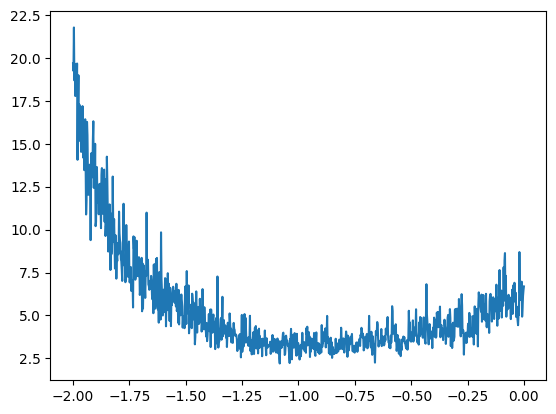

In [93]:
lr_list = []
loss_list = []
lri = torch.linspace(-2, 0, 1000)
for i in range(1000):
  # mini-batch
  idx = torch.randint(0, X.shape[0], (32,))
  X_batch = X[idx]
  Y_batch = Y[idx]
  # forward pass
  emb = C[X_batch]
  h = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch)
  # print('loss is', loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update weights
  lre = 10**lri[i]
  for p in parameters:
    p.data += -lre * p.grad

  # track states
  lr_list.append(lri[i])
  loss_list.append(loss.item())

plt.plot(lr_list, loss_list)

### 可视化结果

从下图可以看到，红线区域的值比较理想。简单起见，我们可以选 -1(learning-rate = 0.1) 作为我们的learning rate。
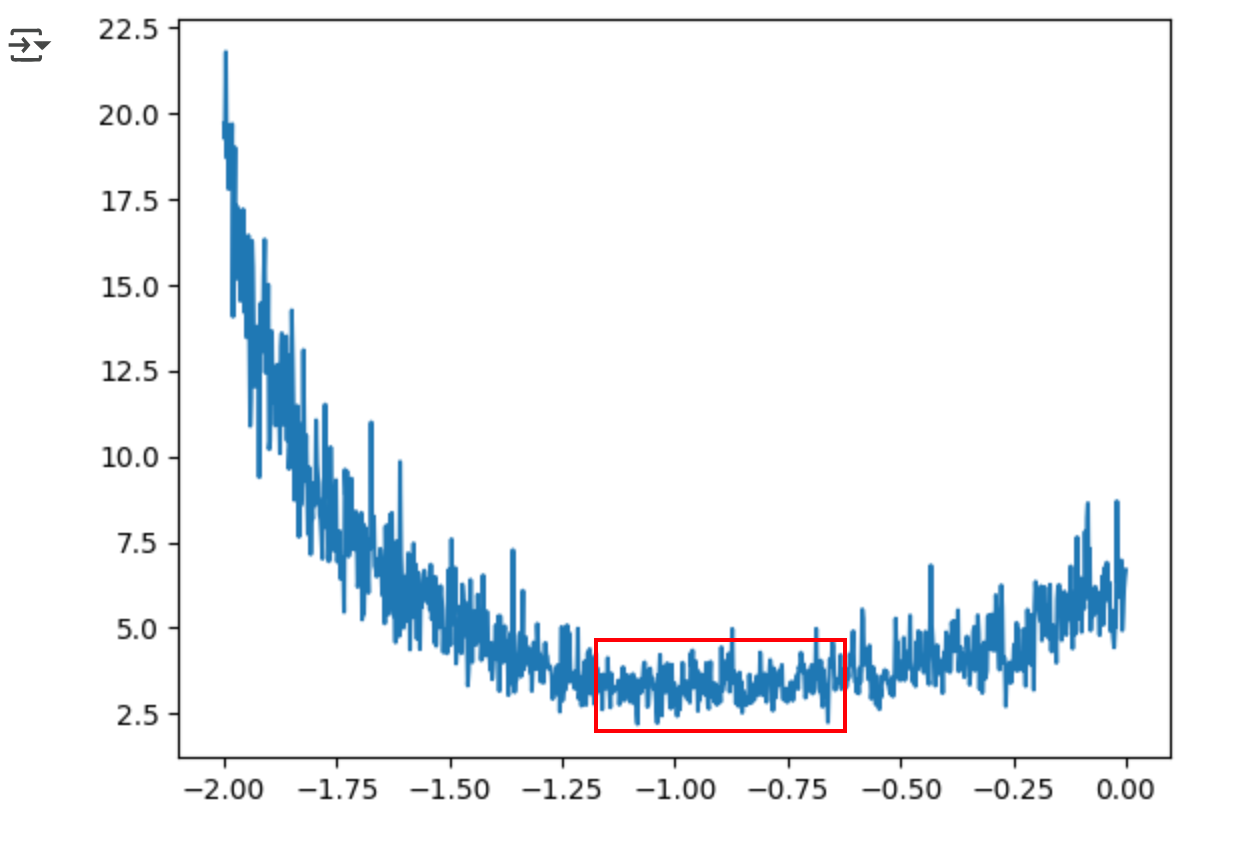

## 真正地开始训练
1. 固定learning-rate=0.1
2. 设定iteration到一个比较大的值，比如10000
3. 用overall的loss来检验结果，避免mini-batch的干扰。
4. 第一次执行，loss就到了 2.42
5. 执行 3-4次以后，loss来到 2.39，就不太下降了。

In [105]:
for i in range(10000):
  # mini-batch
  idx = torch.randint(0, X.shape[0], (32,))
  X_batch = X[idx]
  Y_batch = Y[idx]
  # forward pass
  emb = C[X_batch]
  h = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch)
  # print('loss is', loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update weights
  for p in parameters:
    p.data += -0.01 * p.grad

# check overall loss
emb = C[X]
h = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(h)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
print('overall loss is', loss.item())

overall loss is 2.303616762161255


## 现在，开始 learning rate decay
- 设置learning rate为之前的 1/10, 即 0.01。
- 复用上面的代码进行训练。
- loss从 2.39 下降到 2.30 并保持稳定。

# 改进4 - prevent overfitting (57:00)



## Split training data
- train 80%
- dev / validation 10%
- test 10%

In [112]:
# build_data_set
def build_data_set(words):
  # setup training data
  block_size = 3
  xs = []
  ys = []
  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      idx = stoi[ch]
      xs.append(context)
      ys.append(idx)
      # print(''.join(itos[con] for con in context), '---->', ch)
      context = context[1:] + [idx]
  X = torch.tensor(xs)
  Y = torch.tensor(ys)
  print(X.shape, Y.shape)
  return X, Y

random.seed(40)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
X_train, Y_train = build_data_set(words[:n1])
X_dev, Y_dev = build_data_set(words[n1:n2])
X_test, Y_test = build_data_set(words[n2:])

torch.Size([182433, 3]) torch.Size([182433])
torch.Size([22825, 3]) torch.Size([22825])
torch.Size([22888, 3]) torch.Size([22888])


## Train on train_split, check loss of train and dev

In [117]:
# init weights
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2))
W1 = torch.randn((6, 100))
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [C, W1, b1, W2, b2]
pnum = sum(p.nelement() for p in parameters)
print('number of parameter is', pnum)
# set common fields of parameter
for p in parameters:
  p.generator = g
  p.requires_grad = True

number of parameter is 3481


In [127]:
# train the model on train split
for i in range(10000):
  # mini-batch
  idx = torch.randint(0, X_train.shape[0], (32,))
  X_batch = X_train[idx]
  Y_batch = Y_train[idx]
  # forward pass
  emb = C[X_batch]
  h = emb.view(-1, 6) @ W1 + b1
  h = torch.tanh(h)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y_batch)
  # print('loss is', loss.item())
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update weights
  for p in parameters:
    p.data += -0.01 * p.grad

# check train loss
emb = C[X_train]
h = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(h)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print('train_split loss is', loss.item())


train_split loss is 2.337387800216675


## Compare loss on train_split and dev_split
check if we got high-bias(underfitting) or high-variant(overfitting)

In [128]:
# check train loss
emb = C[X_train]
h = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(h)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_train)
print('train_split loss is', loss.item())

# check dev loss
emb = C[X_dev]
h = emb.view(-1, 6) @ W1 + b1
h = torch.tanh(h)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_dev)
print('dev_split loss is', loss.item())

train_split loss is 2.337387800216675
dev_split loss is 2.3361637592315674


## 根据结果确定下一步
1. underfitting -> 扩大网络规模，增加参数
2. overfitting -> 缩小网络规模，减少参数

### Increase hidden layer size
效果不大

### Increase embedding dimension

In [130]:
C.shape

torch.Size([27, 2])

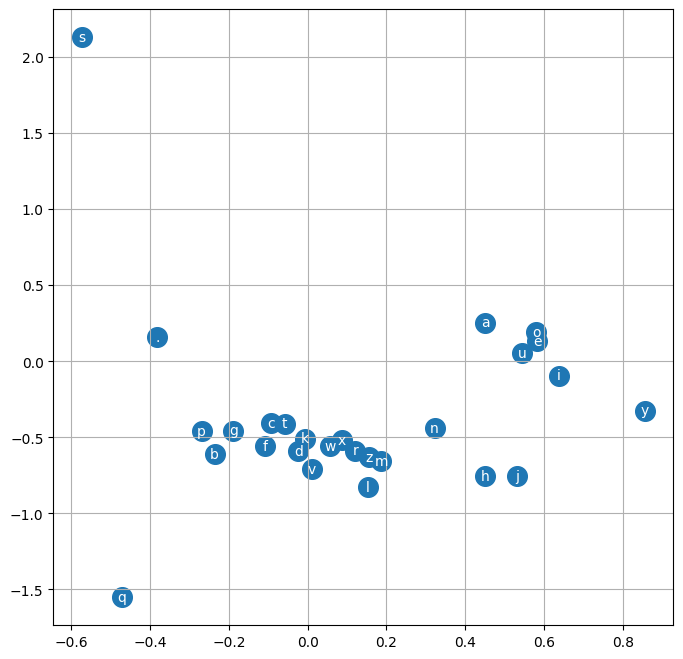

In [134]:
# 增加维度之前，我们先来看看 embedding 学到了什么
# 因为我们没办法可视化二维以上的 embedding
plt.figure(figsize=(8, 8))
# .data 获取纯数据，不带 gradient 信息
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  # .item 获取数据 float, item只能用于包含单个值的 tensor
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')


上图最有意思的一点是， 所有的元音 (a,e,i,o,u) 都聚到了一起。  
说明 embedding 确实学到了一些东西  
It's really cool

# TODO
1. 尝试不同方法，使 loss<2.16, 可以尝试增加embedding dimension, 增加Block-size (目前是3)等
2. Sample with new model, 注意 F.softmax 的使用。

# 教训
1. 定义参数记得加上 `required_grad=True`
```python
for p in parameters:
      p.required_grad = True
```